# QUENIAT Hugo Lab 1

# Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

Last edits:
- 2020/03/24 peeters (change dimensions order)
- 2020/04/27 peeters (added comments on W1, W2 initialization, added comments on A and B)
- 2021/05/05 peeters (add some documentation related to ```W1 -= ...```)
- 2023/05/10 peeters (typos corrections)

Read the "introduction to pytorch" 
- slides: https://perso.telecom-paristech.fr/gpeeters/doc/pytorch/
- video: https://perso.telecom-paristech.fr/gpeeters/video/pytorch.mp4


## Objective:

The objective of this lab is to demonstrate the use of Neural Networks to perform non-linear regression.
We will use a simple NN with 1 hidden layer. The hidden layer has $n_h$ (you will test various values of $n_h$) hidden units and either a ```sigmoid```, ```relu``` or ```tanh``` activation.
Since we perform a regression task the output $\hat{y} \in \mathbb{R}$ and  there is no output activation (linear).

You will perform 1000 iterations (epochs) of SGD to find the parameters.

You will then apply the network to the two datasets A and B.

Note: for this lab, we do not separate the dataset into a train, validation and test part. We simply check the ```capacity``` of the network to model the training data.

**Question**: according to the obtained loss, discuss the choice of ```sigmoid```, ```relu``` or ```tanh```.



### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write a NN model in pytorch. 

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,w2,b2), writting the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a regression problem, we will use a Mean Square Error loss: write it by-hand for Model A and use ```torch.nn.MSELoss``` for Model B and C.

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.05.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package. 
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```. 

### Regularization

- How can you add a Ridge (L2) regularization ? this can be done easely within the definition of the ```optimizer```.
- How can you add a Lasso (L1) regularization ? this has to be done manually at each iteration, by adding something to the loss before backpropagation.

**Question**: discuss the use of the Ridge and Lasso regularization for each dataset.

## Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

## Load the python packages

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## Datasets

We will use two different datasets. For both $x$ has dimensions $(m,n_{in}=1)$ and $y$ has dimensions $(m,n_{out}=1)$ where $m$ is the number of examples.



In [114]:
def F_do_dataset_parab(m):
    x_data = torch.linspace(-1, 1, m)
    noise_data = 0.2*torch.rand(m)
    y_data = x_data.pow(2) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1) 
    return x_data, y_data

def F_do_dataset_sin(m):
    x_data = torch.arange(0, m, dtype=torch.float32)
    noise_data = 0.2*torch.rand(m)
    y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

size of x_data: torch.Size([100, 1])
size of y_data: torch.Size([100, 1])


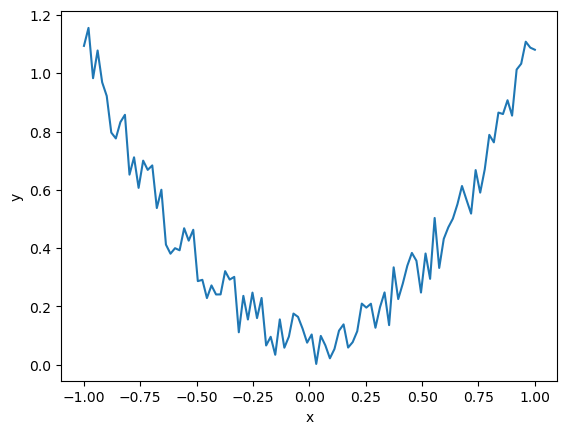

In [129]:
# --- Dataset 1
x_data, y_data = F_do_dataset_parab(m=100)
# --- Dataset 2
#x_data, y_data = F_do_dataset_sin(m=3000)

plt.plot(x_data.numpy(), y_data.numpy());
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Data standardization

We standardize the input data (substract mean and divide by standard-deviation)

In [130]:
# --- START CODE HERE
x_data = (x_data - torch.mean(x_data))/torch.std(x_data) # --- normalize
y_data = (y_data - torch.mean(y_data))/torch.std(y_data) # --- normalize
# --- END CODE HERE

## Hyper-parameters definition

In [131]:
n_in = 1
n_h = 20
n_out = 1

nb_epoch = 40000
learning_rate_alpha = 0.001
param_momentum = 0.01
param_L1_weight = 0.00001
param_L2_weight = 0.001

## Model A (writting the network equations)

For model A, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```. 

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from the ```loss``` variable. 
Then, for all torch tensors you have created and for which you have declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```. 

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward()``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

### Initialize the variables

**Note**: In order to avoid neuron saturation and that all the neurons learn the same thing, the matrix should be initialized to a small random value (see https://pytorch.org/docs/stable/nn.html#linear for details). Because of this, W1 and W2 should be first define as small random; **then** set to ```requires_grad=True```.

In [132]:
# --- START CODE HERE
# Randomly initialize weights
W1 = torch.randn(n_in, n_h, requires_grad=True) 
b1 = torch.randn(n_h ,requires_grad=True)
W2 = torch.randn(n_h, n_out, requires_grad=True)
b2 = torch.randn(n_out, requires_grad=True)
# --- END CODE HERE

### Define the model

We will denote by ```H``` the pre-activation (value before the non-linearity) and by ```A``` the activation (value after the non-linearity).

In [133]:
def model(X):
    
    # --- H is the results of the first projection
    # --- H is then transformed by a non-linearity to A
    
    # --- START CODE HERE
    H = torch.matmul(X, W1) + b1 # projection
    A = nn.ReLU()(H) # non-linearity, application of the activation function
    y_pred = torch.matmul(A, W2) + b2 # prediction
    # --- END CODE HERE
    return y_pred

### Train the model

**Note**: when updating the parameters (W1,b1,W2,b2) you should use an "in-place" update: ```W1 -= ...``` instead of ```W1 = W1 - ...```; otherwise ```W1``` will be replaced by its value and its gradient field will not exist anymore.

In [134]:
for epoch in range(0, nb_epoch):    
    # --- X (m, n_in)
    # --- Y (m, n_out)
    # --- START CODE HERE
    y_pred = model(x_data) # forward pass, y_pred = (m, n_out)
    loss = torch.mean((y_pred - y_data)**2) # --- loss function
    # --- END CODE HERE
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))

    loss.backward() # --- backward propagation
    
    with torch.no_grad():
        # --- START CODE HERE
        # --- update weights
        W1 -= learning_rate_alpha * W1.grad
        b1 -= learning_rate_alpha * b1.grad
        W2 -= learning_rate_alpha * W2.grad
        b2 -= learning_rate_alpha * b2.grad
        # --- END CODE HERE
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        

epoch 0, loss 108.19697570800781
epoch 1000, loss 0.3188146948814392
epoch 2000, loss 0.11090315133333206
epoch 3000, loss 0.06538157910108566
epoch 4000, loss 0.050778064876794815
epoch 5000, loss 0.046921804547309875
epoch 6000, loss 0.0452938973903656
epoch 7000, loss 0.04403294250369072
epoch 8000, loss 0.04311273247003555
epoch 9000, loss 0.04242860898375511
epoch 10000, loss 0.04191373661160469
epoch 11000, loss 0.0414188876748085
epoch 12000, loss 0.04098949581384659
epoch 13000, loss 0.0403459370136261
epoch 14000, loss 0.03948412835597992
epoch 15000, loss 0.03880957141518593
epoch 16000, loss 0.03808669000864029
epoch 17000, loss 0.037647806107997894
epoch 18000, loss 0.037087999284267426
epoch 19000, loss 0.036547061055898666
epoch 20000, loss 0.03597630560398102
epoch 21000, loss 0.03496982157230377
epoch 22000, loss 0.03443257510662079
epoch 23000, loss 0.034037552773952484
epoch 24000, loss 0.03383840620517731
epoch 25000, loss 0.03367441147565842
epoch 26000, loss 0.0333

### Plotting the results

We will super-impose the biases of the first layer to better understand how the model has fit the sinusoidal curve. Please explain what it does.

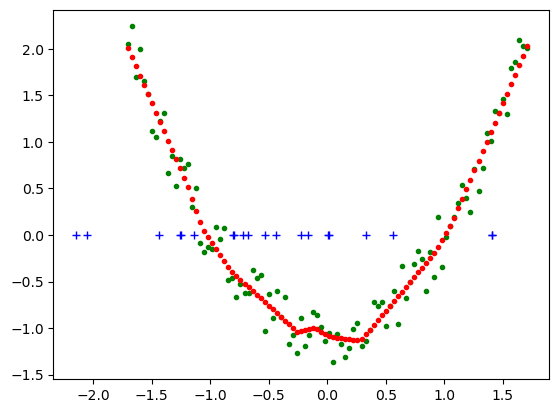

In [135]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g.');
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.');
# super-impose the biases of the first layer
#plt.plot(b1.detach().numpy(), 1, 'bo'); # --- do not why but it does not work on my machine
plt.plot(b1.detach().numpy(), np.zeros(b1.detach().numpy().shape), 'b+');

**Explanation on the bias** :

The biases of the first layer are the values of the neurons before the activation function. Thus, they are used to adjust the position of the activation function (here the ReLu function) and they allow to capture the non linerarity of the data. Hence, we see on the graph that the biases are mainly placed at the non-linearities.

## Model B (using Sequential class)

Here, you will write the network using the nn.Sequential class.
With this you can use the ready-made layers ``torch.nn.Linear``,``torch.nn.Tanh``, ...

In [122]:
# --- START CODE HERE
model = nn.Sequential(nn.Linear(n_in, n_h),nn.ReLU(),nn.Linear(n_h, n_out))
# --- END CODE HERE

## Model C (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. 

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [123]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # --- START CODE HERE
        self.hidden = nn.Linear(n_in, n_h)
        self.predict = nn.Linear(n_h, n_out)
        # --- END CODE HERE
        
    def forward(self, x):
        
        # --- START CODE HERE
        y_pred = self.predict(nn.ReLU()(self.hidden(x)))
        # --- END CODE HERE
        
        return y_pred

# --- START CODE HERE
model = Net()
# --- END CODE HERE

## Model B+C

### Criterion and Optimization

The code of Model A is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model B) or a class definition of the network (model C), we still need to define 
- what we will minimize (the loss to be minimized, i.e. Mean-Square-Error or Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update alogirhtms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

L2 regularization can be done directly in the optimizer under the name ```weight_decay```.

In [124]:
# --- START CODE HERE
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_alpha, momentum=param_momentum)
# --- END CODE HERE

### Training

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

In [125]:
loss_l = []
for epoch in range(nb_epoch):
  
    # --- START CODE HERE
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    
    l1_reg = torch.tensor(0.)
    for param in model.parameters():
        l1_reg += torch.norm(param, p=1)
    loss += param_L1_weight * l1_reg
    loss_l.append(loss)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data))

epoch 0, loss 1.0639045238494873
epoch 1000, loss 0.6515805721282959
epoch 2000, loss 0.5169067978858948
epoch 3000, loss 0.42339110374450684
epoch 4000, loss 0.3556423783302307
epoch 5000, loss 0.30469685792922974
epoch 6000, loss 0.2650611400604248
epoch 7000, loss 0.23330143094062805
epoch 8000, loss 0.20725013315677643
epoch 9000, loss 0.18551570177078247
epoch 10000, loss 0.16717077791690826
epoch 11000, loss 0.15157164633274078
epoch 12000, loss 0.13824023306369781
epoch 13000, loss 0.1268036812543869
epoch 14000, loss 0.11695553362369537
epoch 15000, loss 0.10844213515520096
epoch 16000, loss 0.10104742646217346
epoch 17000, loss 0.09459146112203598
epoch 18000, loss 0.08892327547073364
epoch 19000, loss 0.08391774445772171
epoch 20000, loss 0.07947156578302383
epoch 21000, loss 0.07549986243247986
epoch 22000, loss 0.07193303108215332
epoch 23000, loss 0.06871373951435089
epoch 24000, loss 0.06579520553350449
epoch 25000, loss 0.06313744187355042
epoch 26000, loss 0.06070811301

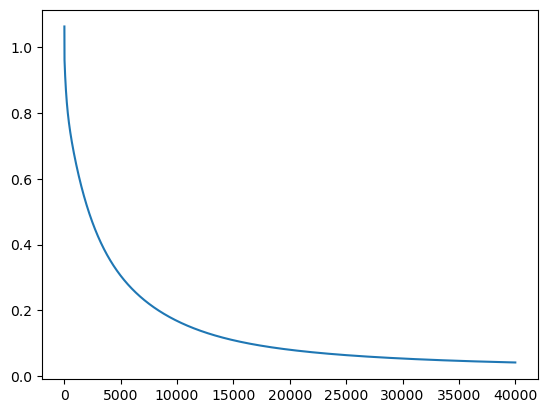

In [126]:
# ----------------
plt.plot([loss.detach().numpy() for loss in loss_l]);

### Plotting results

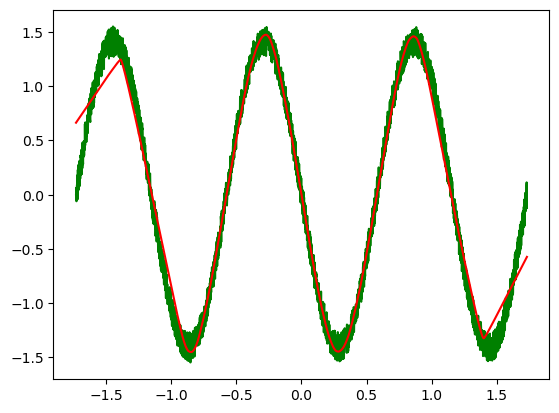

In [127]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r')

### Display the weights and the biases

Now, we want to check the effect of L1 regularization. For this you will plot the values of the weights of each layers.

[[ 0.5876198 ]
 [ 0.4785219 ]
 [ 0.5724213 ]
 ...
 [-0.16591018]
 [-0.92014676]
 [ 0.6097678 ]]
[-0.26652178  0.15105444 -0.78925985 ...  0.40429303 -0.6629847
 -0.85280627]
[[ 0.05666234 -0.10135749  0.14836253 ... -0.02496852  0.08343305
   0.18804784]]
[-0.02203825]


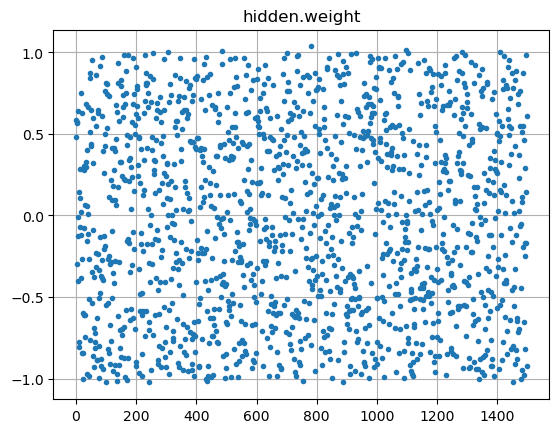

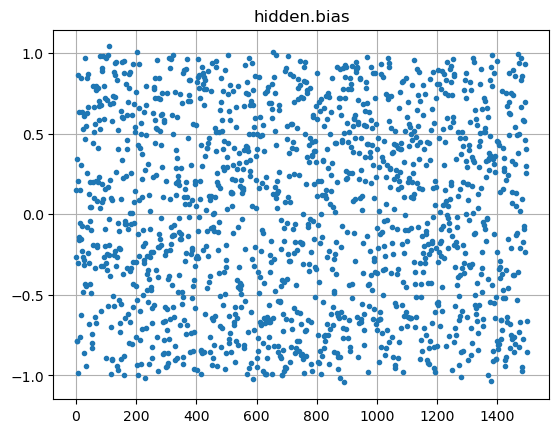

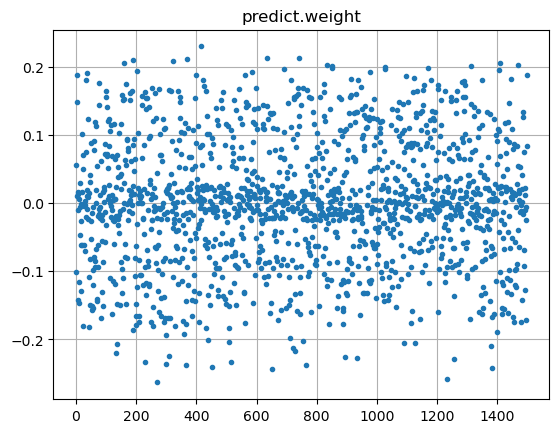

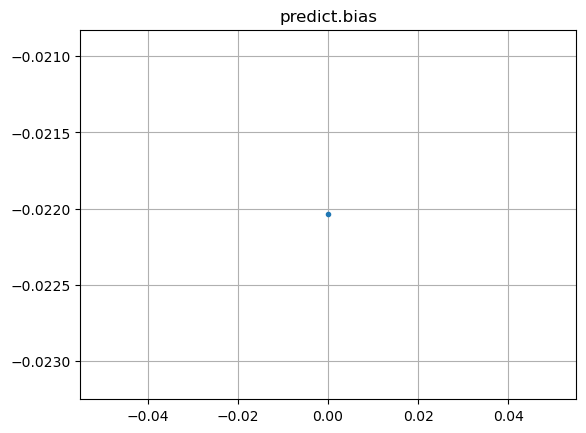

In [128]:
list_l = [{'name':name, 'data':layer.data} for name, layer in model.named_parameters()]
for tmp in list_l:
    plt.figure()
    plt.plot(tmp['data'].flatten().numpy(), '.')
    plt.title(tmp['name'])
    plt.grid(True)
    print(tmp['data'].numpy())

We see that the weights are mostly concentrated towards a zero value. This is the effect of the L1 regularization, it penalizes large values of the weights.